In [1]:
# importing modules
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, cross_validation
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr

C:\Users\James\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Getting data
skaters_url = 'http://www.nhl.com/stats/rest/skaters?isAggregate=false&reportType=basic&isGame=false&reportName=skatersummary&sort=[{%22property%22:%22points%22,%22direction%22:%22DESC%22},{%22property%22:%22goals%22,%22direction%22:%22DESC%22},{%22property%22:%22assists%22,%22direction%22:%22DESC%22}]&cayenneExp=gameTypeId=2%20and%20seasonId%3E=20172018%20and%20seasonId%3C=20172018'

response = requests.get(skaters_url)
response.raise_for_status()
playerData = pd.DataFrame(response.json()['data'])
salariesData = pd.read_csv('Salaries.csv')

In [3]:
# Checking out data features
list(playerData)

['assists',
 'faceoffWinPctg',
 'gameWinningGoals',
 'gamesPlayed',
 'goals',
 'otGoals',
 'penaltyMinutes',
 'playerBirthCity',
 'playerBirthCountry',
 'playerBirthDate',
 'playerBirthStateProvince',
 'playerDraftOverallPickNo',
 'playerDraftRoundNo',
 'playerDraftYear',
 'playerFirstName',
 'playerHeight',
 'playerId',
 'playerInHockeyHof',
 'playerIsActive',
 'playerLastName',
 'playerName',
 'playerNationality',
 'playerPositionCode',
 'playerShootsCatches',
 'playerTeamsPlayedFor',
 'playerWeight',
 'plusMinus',
 'points',
 'pointsPerGame',
 'ppGoals',
 'ppPoints',
 'seasonId',
 'shGoals',
 'shPoints',
 'shiftsPerGame',
 'shootingPctg',
 'shots',
 'timeOnIcePerGame']

In [4]:
# Dropping goalies and defenceman 
playerData = playerData[playerData.playerPositionCode != 'D']
playerData = playerData[playerData.playerPositionCode != 'G']

In [5]:
# Dropping features that shouldn't affect salary and checking that they were dropped
playerData = playerData.drop(columns=['playerBirthCity', 'playerBirthCountry', 'playerBirthStateProvince',
                                      'playerInHockeyHof', 'playerFirstName', 'playerLastName', 'playerNationality', 'playerDraftYear',
                                      'playerDraftRoundNo', 'playerTeamsPlayedFor', 'seasonId', 'playerPositionCode', 'playerShootsCatches',
                                      'playerName', 'faceoffWinPctg', 'gameWinningGoals', 'points', 'penaltyMinutes', 'shiftsPerGame',
                                      'shPoints', 'shGoals', 'playerWeight', 'playerHeight'])
list(playerData)


['assists',
 'gamesPlayed',
 'goals',
 'otGoals',
 'playerBirthDate',
 'playerDraftOverallPickNo',
 'playerId',
 'playerIsActive',
 'plusMinus',
 'pointsPerGame',
 'ppGoals',
 'ppPoints',
 'shootingPctg',
 'shots',
 'timeOnIcePerGame']

In [6]:
# Removing inactive players and checking to make sure all the data is active players
playerData = playerData.query('playerIsActive != 0')
playerData = playerData.drop(columns=['playerIsActive'])

In [7]:
# Setting the index of the dataframe to the players unique nhl player id
playerData = playerData.set_index('playerId')
playerData.head()

,assists,gamesPlayed,goals,otGoals,playerBirthDate,playerDraftOverallPickNo,plusMinus,pointsPerGame,ppGoals,ppPoints,shootingPctg,shots,timeOnIcePerGame
playerId,,,,,,,,,,,,,
8478402,67,82,41,2,1997-01-13,1.0,20,1.3170,5,20,0.1496,274,1293.0975
8473512,68,82,34,1,1988-01-12,22.0,28,1.2439,9,36,0.1761,193,1221.8048
8476453,61,80,39,0,1993-06-17,58.0,15,1.2500,8,36,0.1397,279,1189.2875
8471215,56,78,42,2,1986-07-31,2.0,16,1.2564,14,38,0.1757,239,1139.3974
8477492,58,74,39,3,1995-09-01,1.0,11,1.3108,12,32,0.1373,284,1194.3108


In [8]:
# Checking for any missing values
playerData.isna().sum()

assists                      0
gamesPlayed                  0
goals                        0
otGoals                      0
playerBirthDate              0
playerDraftOverallPickNo    69
plusMinus                    0
pointsPerGame                0
ppGoals                      0
ppPoints                     0
shootingPctg                 0
shots                        0
timeOnIcePerGame             0
dtype: int64

In [9]:
# We can see that 69 forwards went undrafted so we will check to see
# the max draft number
maxDraftNum = playerData['playerDraftOverallPickNo'].max()
print(maxDraftNum)

279.0


In [10]:
# Filling undrafted players draft number with max draft number +1 
playerData['playerDraftOverallPickNo'] = playerData['playerDraftOverallPickNo'].fillna(maxDraftNum + 1)

In [11]:
# Checking to see if the missing values were filled in
playerData.isna().sum()

assists                     0
gamesPlayed                 0
goals                       0
otGoals                     0
playerBirthDate             0
playerDraftOverallPickNo    0
plusMinus                   0
pointsPerGame               0
ppGoals                     0
ppPoints                    0
shootingPctg                0
shots                       0
timeOnIcePerGame            0
dtype: int64

In [12]:
# Checking format and data type of playerBirtDate
print(playerData.playerBirthDate.dtype)
print(playerData[:1].playerBirthDate)

object
playerId
8478402    1997-01-13
Name: playerBirthDate, dtype: object


In [13]:
# Adding age column and roughly calculating age based off birth year *note player data is from 2017-2018 season
playerData['playerBirthDate'] = playerData['playerBirthDate'].apply(lambda x: x[:4])
playerData['age'] = 2017 - playerData['playerBirthDate'].astype(int)
playerData = playerData.drop(columns=['playerBirthDate'])
playerData.head()

,assists,gamesPlayed,goals,otGoals,playerDraftOverallPickNo,plusMinus,pointsPerGame,ppGoals,ppPoints,shootingPctg,shots,timeOnIcePerGame,age
playerId,,,,,,,,,,,,,
8478402,67,82,41,2,1.0,20,1.3170,5,20,0.1496,274,1293.0975,20
8473512,68,82,34,1,22.0,28,1.2439,9,36,0.1761,193,1221.8048,29
8476453,61,80,39,0,58.0,15,1.2500,8,36,0.1397,279,1189.2875,24
8471215,56,78,42,2,2.0,16,1.2564,14,38,0.1757,239,1139.3974,31
8477492,58,74,39,3,1.0,11,1.3108,12,32,0.1373,284,1194.3108,22


In [14]:
# Calculating goals per game
playerData['goalsPerGame'] = playerData['goals']/playerData['gamesPlayed']
playerData['assistsPerGame'] = playerData['assists']/playerData['gamesPlayed']


playerData = playerData.drop(columns=['gamesPlayed'])

In [15]:
# Setting the index for salary dataframe to the players unique nhl player id
salariesData = salariesData.set_index('NHLid')
salariesData.head()

,Salary
NHLid,
8474625,700000.0
8474627,4700000.0
8474628,3500000.0
8468486,1000000.0
8468493,3600000.0


In [16]:
# Checking for missing salaries
salariesData.isna().sum()

Salary    9
dtype: int64

In [17]:
# Dropping missing salaries also getting basic stats on the salaries
# Note that Q3 is at 4,000,000
salariesData.dropna(inplace=True)
print(salariesData.isna().sum())
print(salariesData.describe())

Salary    0
dtype: int64
             Salary
count  8.810000e+02
mean   2.442917e+06
std    2.441001e+06
min    6.500000e+05
25%    7.425000e+05
50%    9.250000e+05
75%    4.000000e+06
max    1.380000e+07


In [18]:
# Calculating high outliers and removing them from data prints the outlier fence just for my info
q3 = 4000000
iqr=iqr(salariesData)
fence = (q3 + (1.5*iqr))
print(fence)
salariesData = salariesData[salariesData.Salary < fence]


8886250.0


In [19]:
# Checking to see if outliers are dropped
salariesData.max()

Salary    8750000.0
dtype: float64

In [20]:
# Joining the two data sets and checking to see if they joined properly
data = playerData.join(salariesData)
list(data)

['assists',
 'goals',
 'otGoals',
 'playerDraftOverallPickNo',
 'plusMinus',
 'pointsPerGame',
 'ppGoals',
 'ppPoints',
 'shootingPctg',
 'shots',
 'timeOnIcePerGame',
 'age',
 'goalsPerGame',
 'assistsPerGame',
 'Salary']

In [21]:
# Checking a known players salary to make sure everything worked by indexing to their player id
data.loc[[8474625]]

,assists,goals,otGoals,playerDraftOverallPickNo,plusMinus,pointsPerGame,ppGoals,ppPoints,shootingPctg,shots,timeOnIcePerGame,age,goalsPerGame,assistsPerGame,Salary
playerId,,,,,,,,,,,,,,,
8474625,6,3,0,60.0,-2,0.2727,1,1,0.081,37,715.6666,28,0.090909,0.181818,700000.0


In [22]:
# Checking how many players have missing salaries
data['Salary'].isna().sum()

21

In [23]:
# Dropping rows with missing salary data and checking to make sure we have no more missing values
data = data.dropna(subset=['Salary'])
data.isna().sum()

assists                     0
goals                       0
otGoals                     0
playerDraftOverallPickNo    0
plusMinus                   0
pointsPerGame               0
ppGoals                     0
ppPoints                    0
shootingPctg                0
shots                       0
timeOnIcePerGame            0
age                         0
goalsPerGame                0
assistsPerGame              0
Salary                      0
dtype: int64

In [24]:
# Checking data types
data.dtypes

assists                       int64
goals                         int64
otGoals                       int64
playerDraftOverallPickNo    float64
plusMinus                     int64
pointsPerGame               float64
ppGoals                       int64
ppPoints                      int64
shootingPctg                float64
shots                         int64
timeOnIcePerGame            float64
age                           int32
goalsPerGame                float64
assistsPerGame              float64
Salary                      float64
dtype: object

In [25]:
# Basic statistics on salary
data.Salary.describe()

count    5.060000e+02
mean     2.232818e+06
std      2.114787e+06
min      6.500000e+05
25%      7.425000e+05
50%      9.250000e+05
75%      3.500000e+06
max      8.750000e+06
Name: Salary, dtype: float64

In [26]:
# Getting info on highest paid player in our dataset
data.loc[data['Salary'].idxmax()]

assists                     3.300000e+01
goals                       3.000000e+01
otGoals                     0.000000e+00
playerDraftOverallPickNo    4.500000e+01
plusMinus                   2.100000e+01
pointsPerGame               9.843000e-01
ppGoals                     1.000000e+01
ppPoints                    2.100000e+01
shootingPctg                1.339000e-01
shots                       2.240000e+02
timeOnIcePerGame            1.166250e+03
age                         3.200000e+01
goalsPerGame                4.687500e-01
assistsPerGame              5.156250e-01
Salary                      8.750000e+06
Name: 8470638, dtype: float64

(array([293.,  12.,  18.,  19.,   9.,  16.,   5.,  16.,  13.,  14.,  28.,
          6.,   5.,  20.,   8.,   6.,   6.,   0.,  10.,   2.]),
 array([ 650000., 1055000., 1460000., 1865000., 2270000., 2675000.,
        3080000., 3485000., 3890000., 4295000., 4700000., 5105000.,
        5510000., 5915000., 6320000., 6725000., 7130000., 7535000.,
        7940000., 8345000., 8750000.]),
 <a list of 20 Patch objects>)

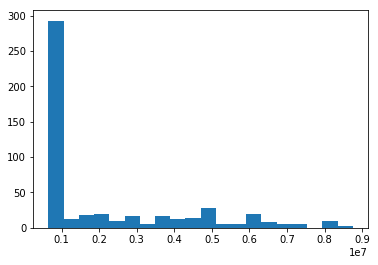

In [27]:
# Histogram for number of players for a salary range with bins set to 20
# to get a little bit more detail
plt.hist(data['Salary'], bins=20)

Text(0,0.5,'Salary')

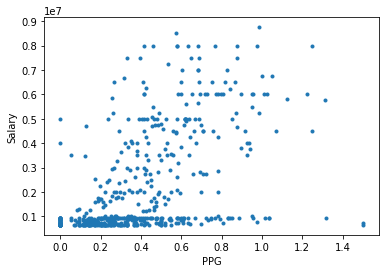

In [28]:
# Scatter plot on salary and a players points per game
plt.scatter(x=data.pointsPerGame, y=data.Salary, marker='.')
plt.xlabel('PPG')
plt.ylabel('Salary')

Text(0,0.5,'Salary')

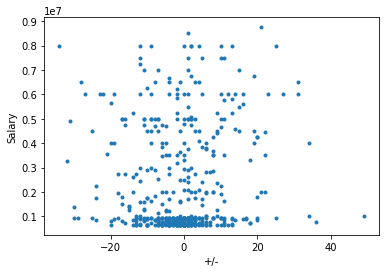

In [29]:
# Scatter plot on salary and a players plus minus
plt.scatter(x=data.plusMinus, y=data.Salary, marker='.')
plt.xlabel('+/-')
plt.ylabel('Salary')

In [30]:
# A players +/- doesnt seem to have any relationship to salary
data = data.drop(columns=['plusMinus'])
list(data)

['assists',
 'goals',
 'otGoals',
 'playerDraftOverallPickNo',
 'pointsPerGame',
 'ppGoals',
 'ppPoints',
 'shootingPctg',
 'shots',
 'timeOnIcePerGame',
 'age',
 'goalsPerGame',
 'assistsPerGame',
 'Salary']

Text(0,0.5,'Salary')

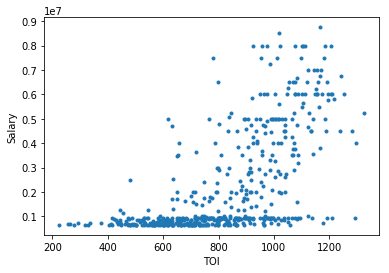

In [31]:
# Scatter plot on salary and a players time on ice
plt.scatter(x=data.timeOnIcePerGame, y=data.Salary, marker='.')
plt.xlabel('TOI')
plt.ylabel('Salary')

Text(0,0.5,'Salary')

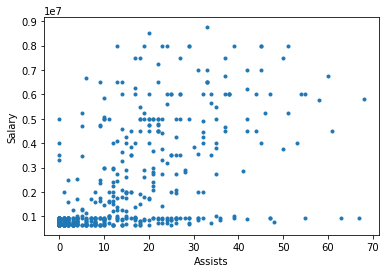

In [32]:
# Scatter plot on salary and a players assists
plt.scatter(x=data.assists, y=data.Salary, marker='.')
plt.xlabel('Assists')
plt.ylabel('Salary')

Text(0,0.5,'Salary')

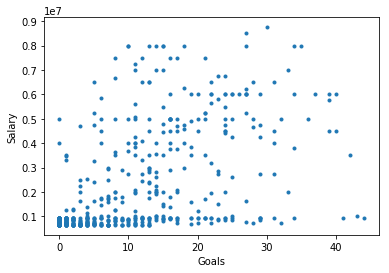

In [33]:
# Scatter plot on salary and a players goals
plt.scatter(x=data.goals, y=data.Salary, marker='.')
plt.xlabel('Goals')
plt.ylabel('Salary')

Text(0,0.5,'Salary')

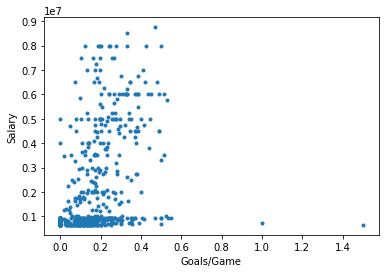

In [34]:
# Scatter plot on salary and a players goals per game
plt.scatter(x=data.goalsPerGame, y=data.Salary, marker='.')
plt.xlabel('Goals/Game')
plt.ylabel('Salary')

Text(0,0.5,'Salary')

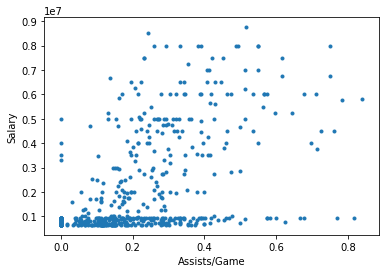

In [35]:
# Scatter plot on salary and a players assists per game
plt.scatter(x=data.assistsPerGame, y=data.Salary, marker='.')
plt.xlabel('Assists/Game')
plt.ylabel('Salary')

Text(0,0.5,'Salary')

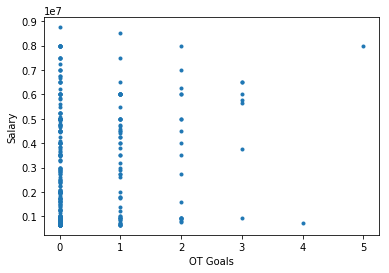

In [36]:
# Scatter plot on salary and a players OT
plt.scatter(x=data.otGoals, y=data.Salary, marker='.')
plt.xlabel('OT Goals')
plt.ylabel('Salary')

In [37]:
# All players are put into 5 categories here so otGoals doesnt help much
data = data.drop(columns=['otGoals'])
list(data)

['assists',
 'goals',
 'playerDraftOverallPickNo',
 'pointsPerGame',
 'ppGoals',
 'ppPoints',
 'shootingPctg',
 'shots',
 'timeOnIcePerGame',
 'age',
 'goalsPerGame',
 'assistsPerGame',
 'Salary']

Text(0,0.5,'Salary')

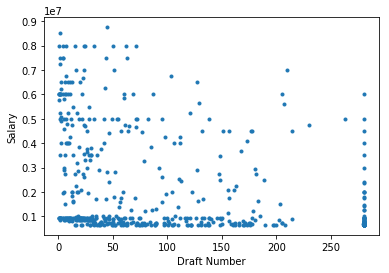

In [38]:
# Scatter plot on salary and a players draft number
plt.scatter(x=data.playerDraftOverallPickNo, y=data.Salary, marker='.')
plt.xlabel('Draft Number')
plt.ylabel('Salary')

In [39]:
# Draft number doesnt have much of a relationship with salary
data = data.drop(columns=['playerDraftOverallPickNo'])
list(data)

['assists',
 'goals',
 'pointsPerGame',
 'ppGoals',
 'ppPoints',
 'shootingPctg',
 'shots',
 'timeOnIcePerGame',
 'age',
 'goalsPerGame',
 'assistsPerGame',
 'Salary']

Text(0,0.5,'Salary')

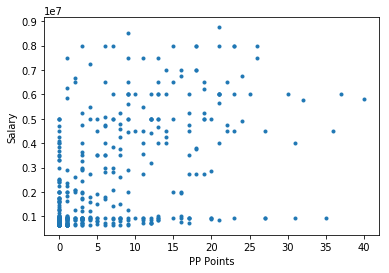

In [40]:
# Scatter plot on salary and a PP points
plt.scatter(x=data.ppPoints, y=data.Salary, marker='.')
plt.xlabel('PP Points')
plt.ylabel('Salary')

Text(0,0.5,'Salary')

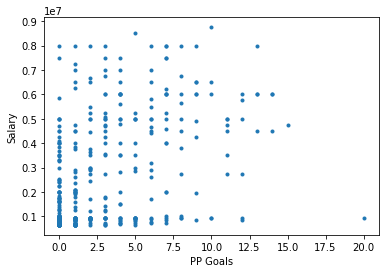

In [41]:
# Scatter plot on salary and a PP goals
plt.scatter(x=data.ppGoals, y=data.Salary, marker='.')
plt.xlabel('PP Goals')
plt.ylabel('Salary')

In [42]:
data = data.drop(columns=['ppGoals'])
list(data)

['assists',
 'goals',
 'pointsPerGame',
 'ppPoints',
 'shootingPctg',
 'shots',
 'timeOnIcePerGame',
 'age',
 'goalsPerGame',
 'assistsPerGame',
 'Salary']

Text(0,0.5,'Salary')

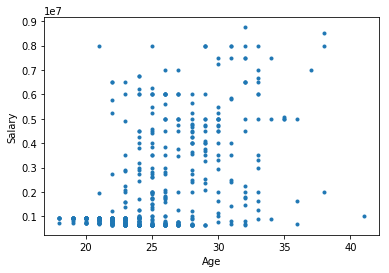

In [43]:
# Scatter plot on salary and a players age
plt.scatter(x=data.age, y=data.Salary, marker='.')
plt.xlabel('Age')
plt.ylabel('Salary')

In [44]:
data = data.drop(columns=['age'])
list(data)

['assists',
 'goals',
 'pointsPerGame',
 'ppPoints',
 'shootingPctg',
 'shots',
 'timeOnIcePerGame',
 'goalsPerGame',
 'assistsPerGame',
 'Salary']

Text(0,0.5,'Salary')

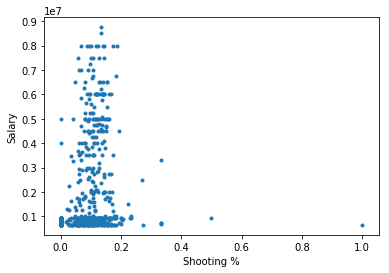

In [45]:
# Scatter plot on salary and shooting %
plt.scatter(x=data.shootingPctg, y=data.Salary, marker='.')
plt.xlabel('Shooting %')
plt.ylabel('Salary')

In [46]:
data = data.drop(columns=['shootingPctg'])
list(data)

['assists',
 'goals',
 'pointsPerGame',
 'ppPoints',
 'shots',
 'timeOnIcePerGame',
 'goalsPerGame',
 'assistsPerGame',
 'Salary']

Text(0,0.5,'Salary')

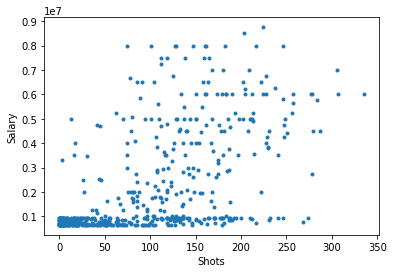

In [47]:
# Scatter plot on salary and shots
plt.scatter(x=data.shots, y=data.Salary, marker='.')
plt.xlabel('Shots')
plt.ylabel('Salary')

In [48]:
data.reset_index(drop=True) 
X = data.drop(columns=['Salary'])
y = data['Salary']
X = preprocessing.scale(X)

In [49]:
# Splitting our dataframe into our taining and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [50]:
# Checking data to make sure it split right
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(404, 8)
(102, 8)
(404,)
(102,)


In [51]:
# Saving data to csv
data.to_csv('NHL_Data.csv', encoding='utf-8')

0.14705882352941177


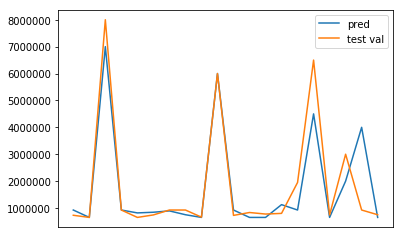

In [52]:
rf = RandomForestClassifier(n_estimators=100,max_features=None)

rf.fit(X_train, y_train)

pred = rf.predict(X_test)

print(rf.score(X_test, y_test))



plt.plot(pred[:20])
plt.plot(y_test.values[:20])
plt.xticks([])
plt.legend(['pred', 'test val'])

In [53]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

lr.score(X_test, y_test)

0.44330574383168814

In [54]:
res = pd.DataFrame({'Predicted':pred,'Actual':y_test})
res = res.reset_index()
res.head(30)

,playerId,Predicted,Actual
0,8478365,1.188854e+06,730000.0
1,8476624,7.554551e+05,650000.0
2,8475793,4.307059e+06,8000000.0
3,8478106,1.851600e+06,925000.0
4,8478542,2.451499e+06,650000.0
5,8480153,1.844667e+06,742500.0
6,8477949,3.219429e+06,925000.0
7,8477973,7.053022e+05,925000.0
8,8475163,1.000390e+06,660000.0
9,8474053,4.275328e+06,6000000.0


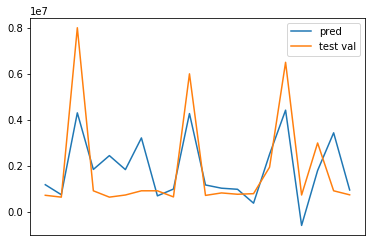

In [55]:
plt.plot(pred[:20])
plt.plot(y_test.values[:20])
plt.xticks([])
plt.legend(['pred', 'test val'])

In [56]:
logr = LogisticRegression()
logr.fit(X_train, y_train)
logr.score(X_test, y_test)

0.16666666666666666